In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from geopy.geocoders import Nominatim
import geojson
from shapely import geometry
from sentinelsat import SentinelAPI
from datetime import date
import utm
from ipyleaflet import Map, Marker, basemaps, basemap_to_tiles
from ipyleaflet import Polygon as ipylPolygon
from dotenv import dotenv_values

from pathlib import Path

In [2]:
conf = dotenv_values('copernicus.env')
conf

OrderedDict([('user', 'osmandaway'), ('passw', 'Daway0123&*')])

## 4 AREA of interest

In [3]:
api=SentinelAPI(conf['user'],conf['passw'],'https://scihub.copernicus.eu/dhus')

In [4]:
adress = {'country':'France', 'city':'Rouffach'}
geolocator = Nominatim(user_agent="osmandaway")

In [5]:
location = geolocator.geocode(adress)
type(location)

geopy.location.Location

In [6]:
location.address

'Rouffach, Thann-Guebwiller, Haut-Rhin, Grand Est, France métropolitaine, 68250, France'

In [7]:
location.latitude, location.longitude

(47.96852955, 7.305268542571866)

In [11]:
latlon = (location.latitude, location.longitude)

m = Map(
    basemap=basemap_to_tiles(basemaps.Esri.WorldImagery),
    center=(latlon[0], latlon[1]),
    zoom=15
)

m.add_layer(Marker(location=latlon))
m

Map(center=[47.96852955, 7.305268542571866], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_…

## Coordinate conversion

In [12]:
utm.from_latlon(location.latitude,location.longitude)

(373505.67235979013, 5314192.1795177, 32, 'T')

In [13]:
x, y, zone, zoneLetter = utm.from_latlon(location.latitude, location.longitude)
x = round(x,2)
y = round(y,2)
print(x,y)

373505.67 5314192.18


In [14]:
offset = 15 * 1000

upl = (x-offset, y+offset)
upr = (x+offset, y+offset)

dwr = (x+offset, y-offset)
dwl = (x-offset, y-offset)

utmCoord = [upl,upr,dwr,dwl]
utmCoord

[(358505.67, 5329192.18),
 (388505.67, 5329192.18),
 (388505.67, 5299192.18),
 (358505.67, 5299192.18)]

In [15]:
geo1_coord = []
geo2_coord = []

for p in utmCoord:
    lat, lon = utm.to_latlon(*p, zone, zoneLetter)
    geo1_coord.append([round(lat,7), round(lon,7)])
    geo2_coord.append([round(lon,7), round(lat,7)])

geo1_coord, geo2_coord

([[48.1002722, 7.0994558],
  [48.1062295, 7.5022523],
  [47.8364043, 7.5100359],
  [47.8305029, 7.1093301]],
 [[7.0994558, 48.1002722],
  [7.5022523, 48.1062295],
  [7.5100359, 47.8364043],
  [7.1093301, 47.8305029]])

# Creating a Polygon

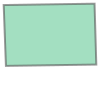

In [16]:
geoPolygon = geometry.Polygon(geo2_coord)
geoPolygon

In [17]:
print(geoPolygon)

POLYGON ((7.0994558 48.1002722, 7.5022523 48.1062295, 7.5100359 47.8364043, 7.1093301 47.8305029, 7.0994558 48.1002722))


In [18]:
geoPolygon.wkt

'POLYGON ((7.0994558 48.1002722, 7.5022523 48.1062295, 7.5100359 47.8364043, 7.1093301 47.8305029, 7.0994558 48.1002722))'

## Coords to goejson file

In [19]:
path_json1 = Path('data/lat_lon.json').resolve()
path_json2 = Path('data/lon_lat.json').resolve()
path_utm = Path('data/polygon_utm.json').resolve()

path_json1, path_json2, path_utm

(WindowsPath('C:/img_proc/lab_img5/data/lat_lon.json'),
 WindowsPath('C:/img_proc/lab_img5/data/lon_lat.json'),
 WindowsPath('C:/img_proc/lab_img5/data/polygon_utm.json'))

In [20]:
lat_lon = geojson.Polygon(geo1_coord)
lon_lat = geojson.Polygon(geo2_coord)

lat_lon, lon_lat

({"coordinates": [[48.100272, 7.099456], [48.10623, 7.502252], [47.836404, 7.510036], [47.830503, 7.10933]], "type": "Polygon"},
 {"coordinates": [[7.099456, 48.100272], [7.502252, 48.10623], [7.510036, 47.836404], [7.10933, 47.830503]], "type": "Polygon"})

In [21]:
data_utm = geojson.Polygon(utmCoord)
data_utm

{"coordinates": [[358505.67, 5329192.18], [388505.67, 5329192.18], [388505.67, 5299192.18], [358505.67, 5299192.18]], "type": "Polygon"}

In [22]:
with open(path_json1, 'w') as f:
    geojson.dump(lat_lon, f, indent=4)

with open(path_json2, 'w') as f:
    geojson.dump(lon_lat, f, indent=4)
    
with open(path_utm, 'w') as f:
    geojson.dump(data_utm, f, indent=4)

## Display the map

In [23]:
latlon = (location.latitude, location.longitude)


m = Map(
    basemap=basemap_to_tiles(basemaps.Esri.WorldTopoMap,"2021-05-08"),
    center=(latlon[0], latlon[1]),
    zoom=10
)

m.add_layer(Marker(location=latlon))
area = ipylPolygon(location=geo1_coord, color='red', fill_opacity=0.1, weight=2)
m.add_layer(area)
m

Map(center=[47.96852955, 7.305268542571866], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_…

## Sentinelsat download image

# API

In [24]:
api = SentinelAPI(conf['user'], conf['passw'], 'https://scihub.copernicus.eu/dhus')

In [25]:
products = api.query(geoPolygon,
                    date=('20220501', '20220531'),
                    platformname='Sentinel-2',
                    cloudcoverpercentage=(0, 20)
                    )

In [26]:
df = pd.DataFrame(products).T
df

,title,link,link_alternative,link_icon,summary,ondemand,generationdate,beginposition,endposition,ingestiondate,...,platformserialidentifier,processinglevel,datastripidentifier,granuleidentifier,identifier,uuid,datatakesensingstart,sensoroperationalmode,tileid,hv_order_tileid
9e693bbb-b8fa-4773-83fc-2e7faf9e35f7,S2B_MSIL2A_20220509T102559_N0400_R108_T32ULU_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2022-05-09T10:25:59.024Z, Instrument: MS...",false,2022-05-09 15:24:16,2022-05-09 10:25:59.024,2022-05-09 10:25:59.024,2022-05-09 22:26:56.511,...,Sentinel-2B,Level-2A,S2B_OPER_MSI_L2A_DS_2BPS_20220509T152416_S2022...,S2B_OPER_MSI_L2A_TL_2BPS_20220509T152416_A0270...,S2B_MSIL2A_20220509T102559_N0400_R108_T32ULU_2...,9e693bbb-b8fa-4773-83fc-2e7faf9e35f7,NaT,NaN,NaN,NaN
dca4816a-4190-498e-9f0c-f70e5894bbde,S2B_MSIL2A_20220509T102559_N0400_R108_T31UGP_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2022-05-09T10:25:59.024Z, Instrument: MS...",false,2022-05-09 15:24:16,2022-05-09 10:25:59.024,2022-05-09 10:25:59.024,2022-05-09 22:07:46.857,...,Sentinel-2B,Level-2A,S2B_OPER_MSI_L2A_DS_2BPS_20220509T152416_S2022...,S2B_OPER_MSI_L2A_TL_2BPS_20220509T152416_A0270...,S2B_MSIL2A_20220509T102559_N0400_R108_T31UGP_2...,dca4816a-4190-498e-9f0c-f70e5894bbde,NaT,NaN,NaN,NaN
a7826863-1fb4-4de1-b015-7b8364a08529,S2B_MSIL1C_20220509T102559_N0400_R108_T31UGP_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2022-05-09T10:25:59.024Z, Instrument: MS...",false,2022-05-09 12:40:04,2022-05-09 10:25:59.024,2022-05-09 10:25:59.024,2022-05-09 18:23:23.721,...,Sentinel-2B,Level-1C,S2B_OPER_MSI_L1C_DS_2BPS_20220509T124004_S2022...,S2B_OPER_MSI_L1C_TL_2BPS_20220509T124004_A0270...,S2B_MSIL1C_20220509T102559_N0400_R108_T31UGP_2...,a7826863-1fb4-4de1-b015-7b8364a08529,2022-05-09 10:25:59.024,INS-NOBS,31UGP,UP31G
ca1c4e5d-0f3d-4527-ba94-588f564a8454,S2B_MSIL1C_20220509T102559_N0400_R108_T32ULU_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2022-05-09T10:25:59.024Z, Instrument: MS...",false,2022-05-09 12:40:04,2022-05-09 10:25:59.024,2022-05-09 10:25:59.024,2022-05-09 17:41:57.212,...,Sentinel-2B,Level-1C,S2B_OPER_MSI_L1C_DS_2BPS_20220509T124004_S2022...,S2B_OPER_MSI_L1C_TL_2BPS_20220509T124004_A0270...,S2B_MSIL1C_20220509T102559_N0400_R108_T32ULU_2...,ca1c4e5d-0f3d-4527-ba94-588f564a8454,2022-05-09 10:25:59.024,INS-NOBS,32ULU,UU32L


## The choice of the smallest cloudy

In [27]:
idx = df.cloudcoverpercentage == df.cloudcoverpercentage.min()
df_1 = df.loc[idx]

print(f'shape: {df_1.shape}\n\nlink: {df_1.link[0]}\n\nuuid: {df_1.uuid[0]}')

shape: (1, 46)

link: https://scihub.copernicus.eu/dhus/odata/v1/Products('ca1c4e5d-0f3d-4527-ba94-588f564a8454')/$value

uuid: ca1c4e5d-0f3d-4527-ba94-588f564a8454


## Download img

In [28]:
img_name = df_1.title.values[0]
img_name

'S2B_MSIL1C_20220509T102559_N0400_R108_T32ULU_20220509T124004'

In [29]:
img_path = Path('imgs/sentinel').resolve()

In [30]:
uuid = df_1.uuid[0]

In [31]:
api.download(uuid, 'imgs/sentinel/')

KeyboardInterrupt: 